# Disciplina: SCC-5830 PROCESSAMENTO DE IMAGENS 01/2018

## Relatório Parcial


Neste relatório são relatados os resultados parciais do projeto.

**--** Para os teste, será utilizado um conjunto com 500 imagens do dataset STL_10.

**--** As imagens foram pré processadas através de qualixação de histogramas.

Dada uma uma imagem de busca, aqui definida como **image_search**, o presente algoritmo, consiste em montar um dataset contendo os vetores de características baseado no histograma de cores das **500 imagens**.

Inicialmente as imagens foram convertidas para um único canal de cor através do método de Luminance e então calculados os histogramas de cores.

**--** O algoritmo **K-means**, divide o dataset em **80** centróides, então faz o agrupamento das imagens em torno de cada centróide, de acordo com a similaridade.

**--** Feito isto, o algoritmo calculo a distância entre a imagem de busca e cada um dos centróides, retornando o centróide mais próximo, bem como os índices associados as imagens relativas àquele centróide.



# Algoritmo

### Importando Módulos

In [107]:
## Importando módulos

import numpy as np
import imageio
import matplotlib.pyplot as plt
import random
from scipy.spatial import distance
from stl10_input import *
#Carregando o conjunto de dados
list_all_images = read_all_images("unlabeled_X.bin")

### Conjunto de imagens  e imagem de busca

In [108]:
option = 2  #Opções para equalização de histogramas

g = 1.2    #parâmetro para o ajuste gamma
batch = 500  #Imagens para teste

#Luminance (único canal de cor)
images = (0.299*list_all_images[0:batch, :, :, 0] + 0.587*list_all_images[0:batch, :, :, 1] + 0.114*list_all_images[0:batch, :, :, 2]).astype(np.uint8)


image_search = list_all_images[50000, :, :, :]

#Imagem de busca
image_test = (0.299*image_search[:, :, 0] + 0.587*image_search[:, :, 1] + 0.114*image_search[:, :, 2]).astype(np.uint8)



### Funções

In [109]:
# Ajuste gamma
def gamma_ajust(img, g):
    p = float(1/g)
    images_eq = img**(p)
    return(images_eq)

# Histograma
def hist(M):
    m, n = M.shape
    hist_color = np.zeros(256).astype(int)
    for i in range(m):
        for j in range(n):
            hist_color[M[i, j]]+=1
    return(hist_color)

# Histograma acumulado
def hist_cumulative(h):
    ha=([0]*256)
    ha[0]=h[0]
    for i in range(1,256):
        ha[i]=ha[i-1]+h[i]
    return(ha)

# Densidade do histograma
def density(hist):
    d_c = hist/(np.sum(hist))
    return(d_c)

# Equalização de histogramas
def equalization(img, ha):
    m, n = img.shape
    image = (np.zeros_like(img)).astype(np.uint8)
    ha = np.array(ha)/(m*n)
    t = np.uint8(255*ha)
    for i in range(m):
        for j in range(n):
            image[i, j] = t[img[i, j]]
    return(image)

### Algoritmo K-means

In [110]:
def kmeans(dataset, centers, threshold):

    ids = np.sort(random.sample(range(0,batch), centers))
    centroids = dataset[ids, :]
    divergence = 2*threshold
    distances = np.zeros((batch, centers)).astype(float)
    while divergence > threshold:
        for i in range(centers):
            for j in range(batch):
                distances[j, i] = distance.euclidean(centroids[i],dataset[j])
        clusters = np.zeros(batch).astype(int)
        for i in range(batch):
            ind = np.where(distances[i] == np.min(distances[i]))
            clusters[i] = ind[0]

        divergence = 0
        for i in range(centers):
            index = np.where(clusters == i)
            old_centroid = centroids[i, :]
            centroids[i, :] = np.mean(dataset[index, :], axis=1)
            divergence = (divergence + distance.euclidean(centroids[i, :],old_centroid))/256

    return(clusters, centroids, centers)

### Pré processamento com ajuste gamma

In [111]:
if option == 1:
    image_test = gamma_ajust(image_test, g)
    for i in range(batch):
         images[i] = gamma_ajust(images[i], g)

### Pré processamento com equalização de histogramas

In [112]:
if option == 2:
    h_it = hist(image_test)
    ha_it = hist_cumulative(h_it)
    image_test = equalization(image_test, ha_it)
    H = np.zeros((batch, 256)).astype(float)
    for i in range(batch):
        H[i] = hist(images[i])
        H[i] = hist_cumulative(H[i])
        images[i] = equalization(images[i], H[i])

In [113]:
%matplotlib inline

## Imagem de busca

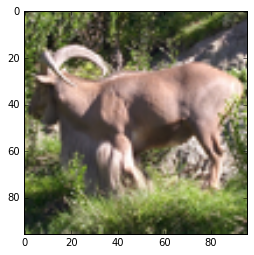

In [114]:
plt.imshow(image_search)
plt.show()

### Extração de característica - Cores

In [115]:
H_color = np.zeros((batch, 256)).astype(int)
d_c = np.zeros((batch, 256)).astype(float)
for i in range(batch):
    H_color[i] = hist(images[i])
    d_c[i] = density(H_color[i])
dc_it = density(ha_it)


### K - means aplicado aos vetores de características

In [116]:
clusters, centroids, centers = kmeans(d_c, 80, 1e-7)
dist_min = 1000

#Retorna o centróide mais próximo à imagem de busca o índice para identificação das imagens
for i in range(centers):
     closest = distance.euclidean(centroids[i, :],dc_it)
     if closest < dist_min:
         dist_min = closest
         ind = i

### Imagens de retorno

In [117]:
#Retorna os índices das imagens referentes ao centróide selecionado
indices = np.where(clusters == ind)
print(indices)
#Retorna as imagens do dataset mais parecidas com a imagem de busca
return_images = list_all_images[indices, :]
print(return_images.shape)
m, n, j, k, l = return_images.shape

(array([  3,  13,  15,  18,  19,  25,  28,  29,  30,  39,  40,  49,  51,
        57,  60,  61,  65,  74,  77,  82,  86,  87, 107, 115, 116, 129,
       133, 137, 138, 140, 142, 144, 153, 156, 157, 160, 164, 171, 181,
       182, 192, 197, 208, 217, 224, 230, 232, 233, 237, 245, 252, 259,
       263, 266, 267, 270, 273, 279, 298, 304, 310, 313, 326, 332, 339,
       349, 352, 360, 363, 376, 391, 395, 400, 409, 412, 414, 417, 425,
       437, 441, 469, 470, 471, 475, 490, 493, 499]),)
(1, 87, 96, 96, 3)


In [118]:
%matplotlib inline

## Exemplos de imagens que são retornadas

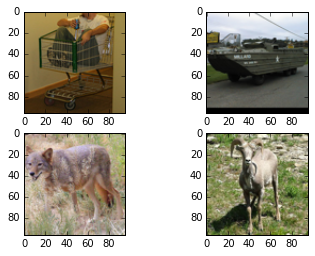

In [119]:
plt.subplot(221)
plt.imshow(return_images[0, 1, :, :, :])
plt.subplot(222)
plt.imshow(return_images[0, 10, :, :, :])
plt.subplot(223)
plt.imshow(return_images[0, 20, :, :, :])
plt.subplot(224)
plt.imshow(return_images[0, 30, :, :, :])
plt.show()

## Limitações

Como a busca é feita através do histograma de cores, isso não diz muito sobre o conteúdo da imagem em si.
Para os primeiros testes as imagens foram convertidas para um único canal de cor, o que também influencia nos resultados. 

# Próximos passos 


**#** Testar o algoritmo para um conjunto maior de imagens (quanto for possível alocar na memória)

**#** Implementar o histograma de cores para cada canal RGB;;

**#** Implementar os descritores de textura de Haralick para a classificação;

**#** Comparar os resultados quando feita a busca através de histograma de cores e textura.